Alunos: Daniel de Paula, Gustavo Guerreiro e Mayara Cardoso Simões

# Trabalho Final de Aprendizado de Máquina sobre Visão Computacional: Classificação de Imagens de Cães e Gatos

O dataset utilizado é de propriedade da Microsoft e está disponível em: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset

## Separação dos Dados em Treino, Teste e Validação

A primeira etapa da implementação é a de separação dos dados. Inicialmente o diretório se encontra no formato:
```
PetImages/
├── Cat
└── Dog
```

Como uma Rede Neural necessita de uma separação entre treino, teste e possivelmente validação, o dataset será reorganizado para seguir a seguinte estrutura mais comum nesse tipo de implementação:
```
dataset/
├── train/
│   ├── Cat/
│   └── Dog/
├── val/
│   ├── Cat/
│   └── Dog/
└── test/
    ├── Cat/
    └── Dog/
```
Para usar essa estrutura se utilizou a classe GeneratorBasedBuilder do TensorFlow para fazer a divisão mais eficiente e monstar a estrutura em treino, validação e teste.

## Importação das bibliotecas

In [1]:
from os import path
from glob import glob
from random import Random
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow_datasets.core import GeneratorBasedBuilder, DatasetInfo, Version

import imghdr
import tensorflow as tf
import tensorflow_datasets as tfds

C:\Users\SANCES_502\AppData\Local\Temp\ipykernel_17284\939048606.py:8: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


## Definição da Classe do Dataset

Para organizar o dataset de uma forma mais eficiente foi criada a classe CatsDogs.
Inicialmente se tem uma função auxiliar chamada listar_imagens_validas, ela é usada para checar se a imagem sendo tratada é de fato um jpg válido ou foi corrompido.

Já a classe CatsDogs em si possui três métodos:
* _info: contém as informações contidas no dataset, no caso uma imagem de 3 dimensões (altura, largura e cor RGB) e o rótulo podendo ser "Cat" ou Dog.
* _split_generators: método principal que busca nas pastas as imagens dos gatos e cães, separa cada grupo em treino, validação e teste e então junta as imagens de cada animal.
* _generate_examples: usado para gerar os dados retornados em si, pegando cada imagem e atribuindo um id para ela.

In [2]:
def listar_imagens_validas(pasta, label):
    caminhos = glob(f"{pasta}/*")
    validos = []
    for caminho in caminhos:
        if imghdr.what(caminho) == "jpeg":
            validos.append((caminho, label))
    return validos


class CatsDogs(GeneratorBasedBuilder):
    VERSION = Version("1.0.0")
    SEED = 42
    PASTA_PADRAO = "PetImages"

    def _info(self):
        return DatasetInfo(
            builder=self,
            features=tfds.features.FeaturesDict({
                "image": tfds.features.Image(shape=(None, None, 3)),
                "label": tfds.features.ClassLabel(names=["Cat", "Dog"]),
            })
        )

    def _split_generators(self, dl_manager):
        raiz = self.PASTA_PADRAO

        gatos = listar_imagens_validas(f"{raiz}/Cat", 0)
        caes = listar_imagens_validas(f"{raiz}/Dog", 1)

        gatos_treino, gatos_resto = train_test_split(gatos, test_size=0.3, random_state=self.SEED)
        gatos_val, gatos_test = train_test_split(gatos_resto, test_size=0.5, random_state=self.SEED)

        caes_treino, caes_resto = train_test_split(caes, test_size=0.3, random_state=self.SEED)
        caes_val, caes_test = train_test_split(caes_resto, test_size=0.5, random_state=self.SEED)

        rng = Random(self.SEED)
        treino = gatos_treino + caes_treino
        rng.shuffle(treino)

        val = gatos_val + caes_val
        rng.shuffle(val)

        teste = gatos_test + caes_test
        rng.shuffle(teste)

        return {
            "train": self._generate_examples(treino),
            "val": self._generate_examples(val),
            "test": self._generate_examples(teste)
        }

    def _generate_examples(self, arquivos):
        for caminho, rotulo in arquivos:
            if not path.isfile(caminho):
                continue
            yield caminho, {"image": caminho, "label": rotulo}


## Instanciamento dos Datasets
A classe CatsDogs é instanciada e os datasets são construídos e carredos em variáveis.

In [3]:
builder = CatsDogs()
builder.download_and_prepare()

ds_train = builder.as_dataset(split="train")
ds_val = builder.as_dataset(split="val")
ds_test = builder.as_dataset(split="test")

## Pré-Processamento
As imagens são pré processados, tendo inicialmente o seu tamanho ajustado e então os seus valores normalizados do formato RGB (0-255, 0-255, 0-255) para (0.0-1.0, 0.0-1.0, 0.0-1.0).

In [4]:
TAMANHO = 128

def preprocessamento(dicionario):
    image = dicionario["image"]
    label = dicionario["label"]
    image = tf.image.resize(image, (TAMANHO, TAMANHO))
    image = tf.cast(image, tf.float32) / 255.0

    return image, label

Além de aplicar o pré-processamento, os dados são organizados para serem divididos em batches para facilitar o processamento na rede e o prefetch para agilizar o processo de carregamento dos batches enquanto a rede é treinada.

In [5]:
BATCH = 32
ds_train = ds_train.map(preprocessamento).batch(BATCH).prefetch(tf.data.AUTOTUNE)
ds_val   = ds_val.map(preprocessamento).batch(BATCH).prefetch(tf.data.AUTOTUNE)
ds_test  = ds_test.map(preprocessamento).batch(BATCH).prefetch(tf.data.AUTOTUNE)

## Construção do Modelo
Utilizando a arquitetura da rede neural MobileNetV2, congelamos o conhecimento da rede e aplicamos na construção do nosso modelo.


In [6]:
# Definir o modelo base de Transfer Learning
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(TAMANHO, TAMANHO, 3), # Nossa forma de entrada (128, 128, 3)
    include_top=False,                 # Não incluir a camada final (de 1000 classes)
    weights='imagenet'                 # Carregar os pesos treinados no ImageNet
)

# Congelar o modelo base
# Não queremos retreinar o que ele já sabe (o que é uma borda, textura, etc.)
base_model.trainable = False

In [8]:
def construir_modelo():
    modelo = models.Sequential([
        layers.Input(shape=(TAMANHO, TAMANHO, 3)),

        # 1. Camada de Data Augmentation
        # importante para evitar overfitting
        data_augmentation,

        # 2. O Modelo Base (Congelado)
        base_model,

        # 3. Camadas de Classificação (Nosso "Topo")
        #    Substitui o 'Flatten' por um Pooling Global.
        #    Reduz os features de 4x4x1280 (do MobileNet) para 1280.
        layers.GlobalAveragePooling2D(),

        # 5. Camada de Dropout para regularizar nosso classificador
        layers.Dropout(0.2),

        # 6. Camada de Saída Final (Gato ou Cão)
        layers.Dense(2, activation='softmax')
    ])

    # Compila o modelo com uma taxa de aprendizado (learning_rate)
    # um pouco mais baixa, o que é bom para Transfer Learning
    modelo.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return modelo

## Treinamento
O modelo arquitetado é então rodado.

In [ ]:
# Camada para "fabricar" novas imagens
data_augmentation = models.Sequential(
    [
        layers.RandomFlip("horizontal"), # Inverte a imagem horizontalmente
        layers.RandomRotation(0.1),      # Gira a imagem em até 10% (aprox 36 graus)
        layers.RandomZoom(0.1),        # Dá um zoom de até 10%
    ],
    name="data_augmentation",
)

model = construir_modelo()
historico = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10
)


Epoch 1/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6187 - loss: 0.7867

In [10]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# 1. Extrair os rótulos verdadeiros (y_true) do dataset de teste
# Precisamos iterar no ds_test para pegar os lotes de rótulos e concatená-los
y_true = np.concatenate([y for x, y in ds_test], axis=0)

# 2. Gerar as previsões (y_pred) do modelo no dataset de teste
# O model.predict já processa todos os lotes
predictions = model.predict(ds_test)
y_pred = np.argmax(predictions, axis=1) # Pega o índice da maior probabilidade (0 ou 1)

# 3. Obter os nomes das classes (ex: ["Cat", "Dog"])
target_names = builder.info.features['label'].names

# 4. Imprimir o relatório de classificação
print("--- Relatório de Classificação ---")
print(classification_report(y_true, y_pred, target_names=target_names))

# Imprimir a acurácia geral separadamente (embora já esteja no relatório)
print(f"Acurácia Geral: {accuracy_score(y_true, y_pred):.4f}")

116/116 ━━━━━━━━━━━━━━━━━━━━ 19s 155ms/step
--- Relatório de Classificação ---
              precision    recall  f1-score   support

         Cat       0.96      0.96      0.96      1859
         Dog       0.96      0.96      0.96      1853

    accuracy                           0.96      3712
   macro avg       0.96      0.96      0.96      3712
weighted avg       0.96      0.96      0.96      3712

Acurácia Geral: 0.9609


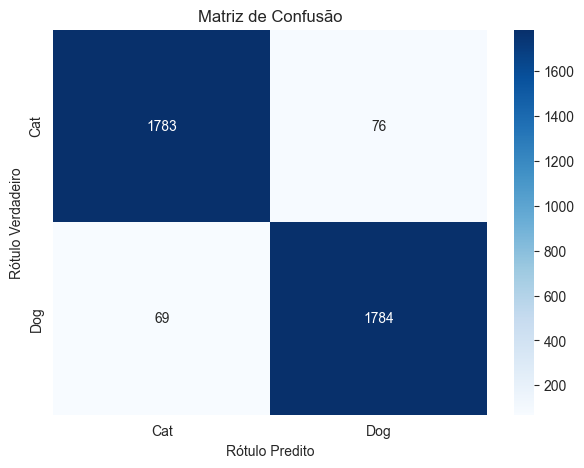

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Calcular a matriz de confusão
cm = confusion_matrix(y_true, y_pred)

# 2. Visualizar a matriz
plt.figure(figsize=(7, 5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)

plt.xlabel('Rótulo Predito')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()